KeyboardInterrupt: 

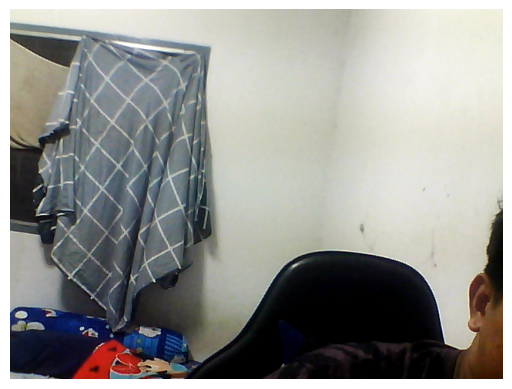

In [2]:
import os
import cv2
import face_recognition
import mediapipe as mp
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# ตั้งค่าที่อยู่ของโฟลเดอร์ที่ต้องการตรวจสอบ
folder_path = "C:/Users/Lucifer/Downloads/ai/saved_face_image"
hand_folder_path = "C:/Users/Lucifer/Downloads/ai/saved_face_image/hand"

# เปิดกล้อง
video_capture = cv2.VideoCapture(0)

# สร้างลิสต์เพื่อเก็บการเข้ารหัสใบหน้าจากทุกไฟล์ในโฟลเดอร์
known_face_encodings = []
known_face_names = []

# โหลดใบหน้าทั้งหมดจากโฟลเดอร์
for file_name in os.listdir(folder_path):
    if file_name.endswith(('.jpg', '.png')):  # ตรวจสอบเฉพาะไฟล์ภาพ
        file_path = os.path.join(folder_path, file_name)
        
        # โหลดภาพใบหน้าที่บันทึกไว้เพื่อใช้ในการเปรียบเทียบ
        known_image = face_recognition.load_image_file(file_path)
        
        # เข้ารหัสใบหน้าที่โหลด
        encodings = face_recognition.face_encodings(known_image)
        
        # ตรวจสอบว่ามีการเข้ารหัสหรือไม่
        if encodings:
            known_face_encodings.append(encodings[0])  # เพิ่มการเข้ารหัสที่พบ
            known_face_names.append(file_name)  # ใช้ชื่อไฟล์เป็นชื่อ
        else:
            print(f"ไม่พบใบหน้าในไฟล์: {file_path}")

# โหลดภาพสัญลักษณ์มือที่บันทึกไว้สำหรับการเปรียบเทียบ
hand_images = {}
for file_name in os.listdir(hand_folder_path):
    if file_name.endswith(('.jpg', '.png')):  # ตรวจสอบเฉพาะไฟล์ภาพ
        file_path = os.path.join(hand_folder_path, file_name)
        hand_image = cv2.imread(file_path)
        hand_images[file_name] = hand_image

# ตั้งค่าการตรวจจับมือ
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

try:
    while True:
        ret, frame = video_capture.read()
        
        if not ret:
            print("ไม่สามารถเปิดกล้องได้")
            break

        # แปลงภาพเป็น RGB (เพราะ face_recognition ใช้ RGB)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # ตรวจจับใบหน้าในภาพ (ตำแหน่งใบหน้า)
        face_locations = face_recognition.face_locations(rgb_frame)
        
        # เข้ารหัสใบหน้าที่ตรวจพบ (เพื่อใช้เปรียบเทียบ)
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
        
        # ตรวจจับมือ
        results = hands.process(rgb_frame)

        finger_position = None  # ตั้งค่าเริ่มต้น
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # วาดจุดบนมือที่ตรวจพบ
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # ตรวจสอบตำแหน่งมือ
                if hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y < hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y:
                    finger_position = "อยู่ในตำแหน่งที่ต้องการ"
                else:
                    finger_position = "ไม่อยู่ในตำแหน่งที่ต้องการ"

        for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
            # เปรียบเทียบใบหน้าที่ตรวจพบกับใบหน้าที่บันทึกไว้
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            
            # วาดกรอบรอบใบหน้า
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
            
            name = "ไม่ปลดล็อก"  # ชื่อเริ่มต้นถ้าไม่พบใบหน้าที่ตรงกัน

            if True in matches:
                first_match_index = matches.index(True)  # หา index ของใบหน้าที่ตรงกัน
                name = known_face_names[first_match_index]  # ดึงชื่อไฟล์ที่ตรงกัน
                
                # แสดงข้อความว่าตรงกัน
                if finger_position == "อยู่ในตำแหน่งที่ต้องการ":
                    cv2.putText(frame, f"{name} ปลดล็อก", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                    print(f"{name} ปลดล็อกสำเร็จ")
                else:
                    cv2.putText(frame, "มือไม่อยู่ในตำแหน่งที่ต้องการ", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
                    print(f"{name} ปลดล็อกไม่สำเร็จ: มือไม่อยู่ในตำแหน่ง")
            else:
                # ถ้าไม่ตรงกัน แสดงข้อความ "ไม่ปลดล็อก"
                cv2.putText(frame, "ไม่ปลดล็อก", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
                print("ปลดล็อกไม่สำเร็จ")
        
        # แสดงภาพใน Jupyter Notebook
        clear_output(wait=True)  # ลบผลลัพธ์เก่า
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # แปลง BGR เป็น RGB
        plt.axis('off')  # ปิดการแสดงแกน
        display(plt.gcf())  # แสดงภาพ
        
        # กด 'q' เพื่อออกจากลูป
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    video_capture.release()
    cv2.destroyAllWindows()
